<a href="https://colab.research.google.com/github/kAi3345/Dark-Matter/blob/main/GravitationalWave/GravitationalWave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99254 sha256=b6ae6f0689dd085920dbfe57e63cb3e1a81e745585d6f638f4b97785e4897dd5
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


In [55]:
t0 = 1264316116.4             # GW200129_065458
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', t0 - 48, t0 + 48)

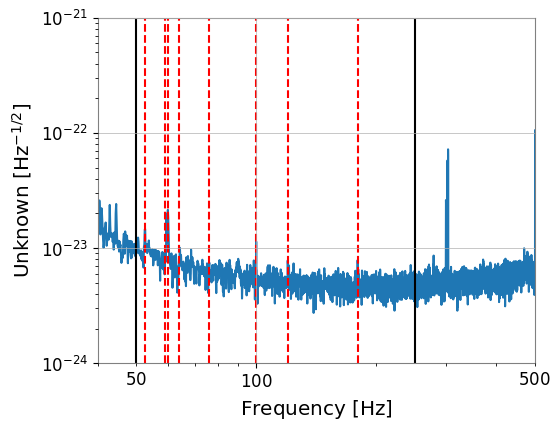

In [57]:
import matplotlib.pyplot as plt

fig2 = hdata.asd(fftlength=8).plot()
plt.xlim(40,500)                                            # set x axis from 40 to 2000
ymin = 1e-24
ymax = 1e-21
plt.ylim(ymin, ymax)
# overlap the frequencies that are unwanted
plt.vlines(52.5, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(59, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(64, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(76, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(100, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red")
# show the boundary of the frequency window
plt.vlines(50, ymin, ymax, linestyle="solid", color="black")
plt.vlines(250, ymin, ymax, linestyle="solid", color="black")

In [58]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50,250, hdata.sample_rate)               # create a frequency window of 50-250Hz so that we can search gravitational wave signal
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (59,60,64,52.5,76,100,120,180)]                      # build a filter for 59, 60, 64, 52.5, 76, 100, 120, 180 Hz frequency since they are noise

zpk = filter_design.concatenate_zpks(bp, *notches)                   # concatenate each of filters together to create a single ZPK

hfilt = hdata.filter(zpk, filtfilt=True)                             # get data after the filter

In [59]:
hdata = hdata.crop(*hdata.span.contract(1))                          # original data from hanford
hfilt = hfilt.crop(*hfilt.span.contract(1))                          # data after croping out all the unwanted frequency

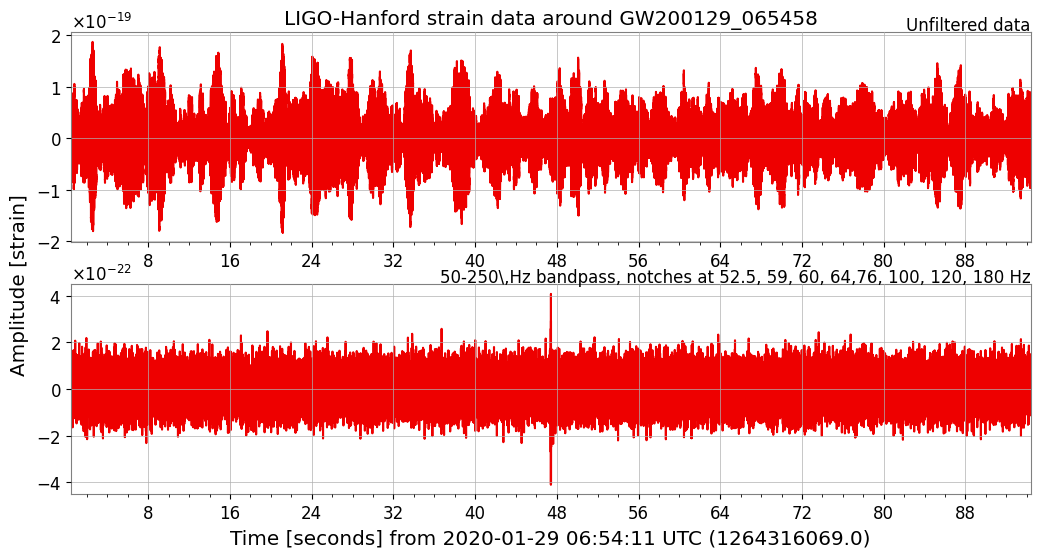

In [61]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW200129_065458')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')                   # notice that the data in the graph is unfiltered
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 52.5, 59, 60, 64,76, 100, 120, 180 Hz',     # signal the data in the graph has been filtered
         transform=ax2.transAxes, ha='right')
plot.show()

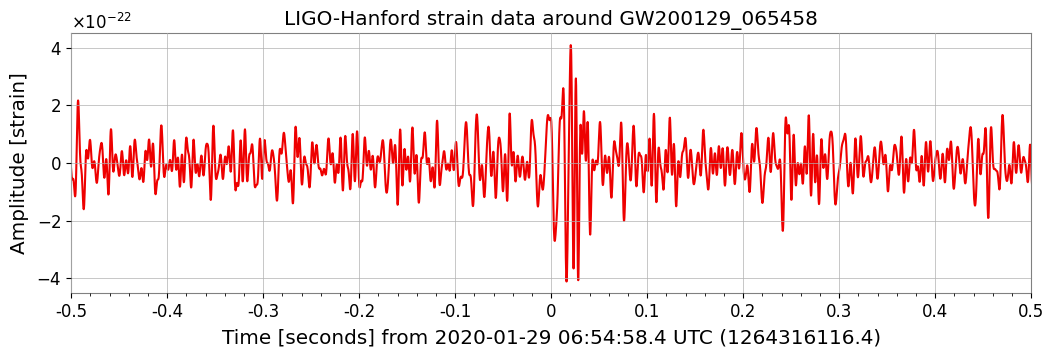

In [62]:
import matplotlib.pyplot as plt

plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW200129_065458')
ax.set_ylabel('Amplitude [strain]')                                     # meaning of y axis
ax.set_xlim(t0 - 0.5, t0 + 0.5)                                         # set the boundary of x axis
ax.set_xscale('seconds', epoch=t0)                                      # the unit of x axis is in seconds
plot.show()

x_val = plt.gca().lines[0].get_xdata()                                  # create a array with the x-value of the plot
y_val = plt.gca().lines[0].get_ydata()                                  # create a array with the y-value of the plot

In [87]:
ldata = TimeSeries.fetch_open_data('L1', t0 - 48, t0 + 48)                      # access data from Livingston Ligo
lfilt = ldata.filter(zpk, filtfilt=True)                                        # filter the unwanted frequency

In [88]:
lfilt.shift('6.9ms')                                                            # signals were separated by 6.9 ms between detectors
lfilt *= -1                                                                     # invert the data from one before comparing them

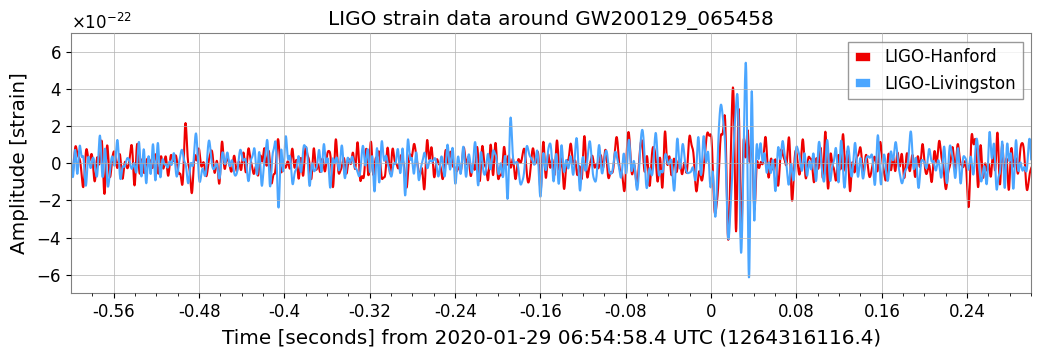

In [89]:
# graph that compare the data from two LIGO detectors
plot = Plot(figsize=[12, 4])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW200129_065458')
ax.set_xlim(t0 -0.6 , t0 + 0.3)
ax.set_xscale('seconds', epoch=t0)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-7e-22, 7e-22)
ax.legend()
plot.show()

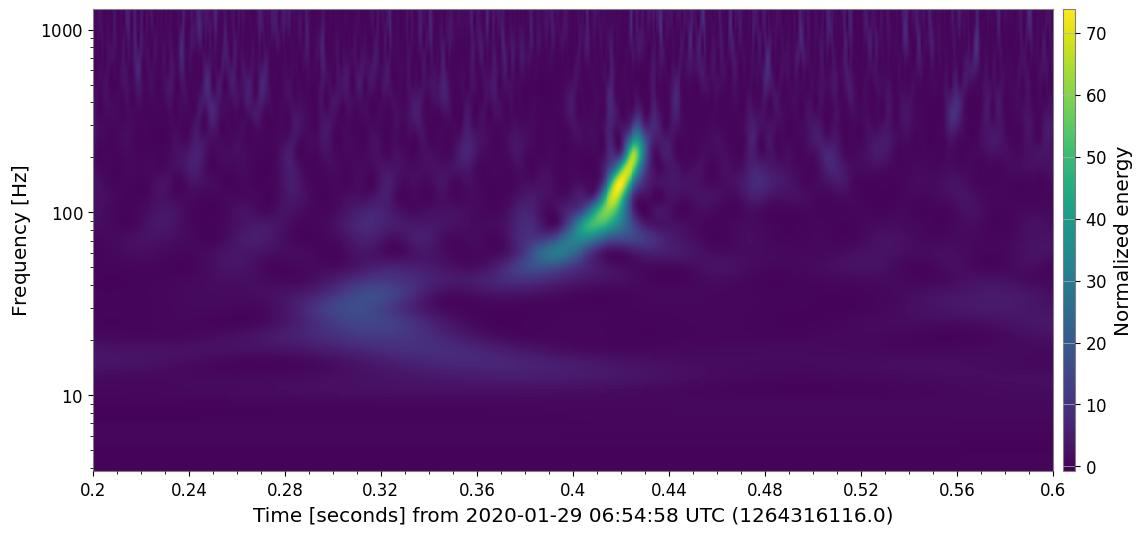

In [90]:
# plot the chirp of the gravitational wave
dt = 0.2                                          # set the width of the graph, in seconds
hq = hfilt.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log')

In [97]:
from scipy.io.wavfile import write
import numpy as np
!pip install pydub
from pydub import AudioSegment

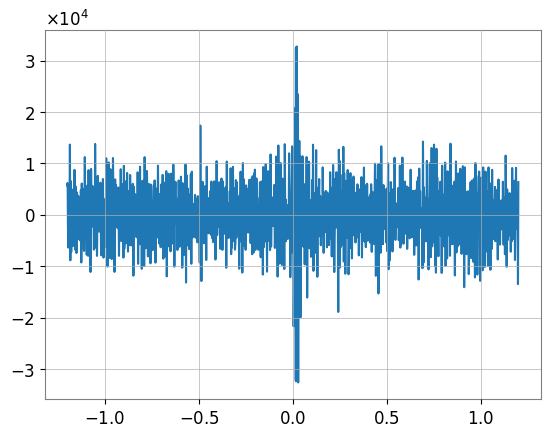

In [105]:
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0+1.2)) & (x_val > (t0-1.2)))              # take 1.2 seconds interval before and after the event
y = y_val[ind]
y = y / np.max(y)                                                    # normalization so that max y equal to 1
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))


In [118]:
from google.colab import files
files.download("example.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
print("fs = ", fs)
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16))


fs =  4096


In [71]:
from google.colab import files

In [99]:
import numpy as np
import astropy.units as u
import astropy.constants as ac

# calculate the total mass of two black holes using the time which merger happened
delta_t = 0.016 * u.second
M_blackholes = delta_t * ac.c**3 / (16 * np.pi * ac.G)
print(M_blackholes.to(u.solMass))

64.62500684042953 solMass


In [96]:
# calculate the radius of merged black hole by using its mass
h = 0.42e-21
radius = 2 * ac.G * M_blackholes / 2.0 / ac.c**2
print("Radius = ", radius.to(u.km))
# calculate the distance of merger place using the radius of black hole
D = radius / h
print("Distance of the merger = ", D.to(1e6 * u.parsec))

Radius =  95.42690318473886 km
Distance of the merger =  7363.274559450338 1e+06 pc


In [108]:
# clip the data to around 1.5 seconds before and after the merger happened
t_clip = 1.5
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0+t_clip)) & (x_val > (t0-t_clip)))
x = x_val[ind]
y = y_val[ind]

In [110]:
# increase the frequency of sound by a factor of 3
up_frequency = 3

y_fft = np.fft.fft(y)                                   # using fourier transform to the amplitude of merger
y_fft_new = np.zeros(np.shape(y_fft), dtype=np.cdouble)
y_fft_old = y_fft

In [114]:
num = len(y_fft)                                        # get the number of data point

# increase the original index by 3, reducing the spacing between waves
for i in np.arange(int(num / up_frequency)):
    y_fft_new[int(i * up_frequency)] = y_fft[int(i)]

y_old = np.fft.ifft(y_fft_old)

for i in np.arange(num):
  if i > (num / 2):
    y_fft_new[i] = np.conjugate(y_fft_new[int(num) - i])

#y_fft_new = np.fft.fftshift(y_fft_new)
y = np.fft.ifft(y_fft_new)


In [115]:
# check if the Fourier transformation work
print(y_fft[0:4], y_fft[-3:])
print(y_fft_new[0:10], y_fft_new[-3:])
print(y_fft_old[0:4], y_fft_old[-3:])

[3.41019557e-22+0.00000000e+00j 3.41039998e-22-1.05029318e-24j
 3.41101334e-22-2.10076659e-24j 3.41203592e-22-3.15160060e-24j] [3.41203592e-22+3.15160060e-24j 3.41101334e-22+2.10076659e-24j
 3.41039998e-22+1.05029318e-24j]
[3.41019557e-22+0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 3.41039998e-22-1.05029318e-24j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 3.41101334e-22-2.10076659e-24j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 3.41203592e-22-3.15160060e-24j] [3.41039998e-22+1.05029318e-24j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j]
[3.41019557e-22+0.00000000e+00j 3.41039998e-22-1.05029318e-24j
 3.41101334e-22-2.10076659e-24j 3.41203592e-22-3.15160060e-24j] [3.41203592e-22+3.15160060e-24j 3.41101334e-22+2.10076659e-24j
 3.41039998e-22+1.05029318e-24j]


<ipython-input-117-94a735049729>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
<ipython-input-117-94a735049729>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")


0.5


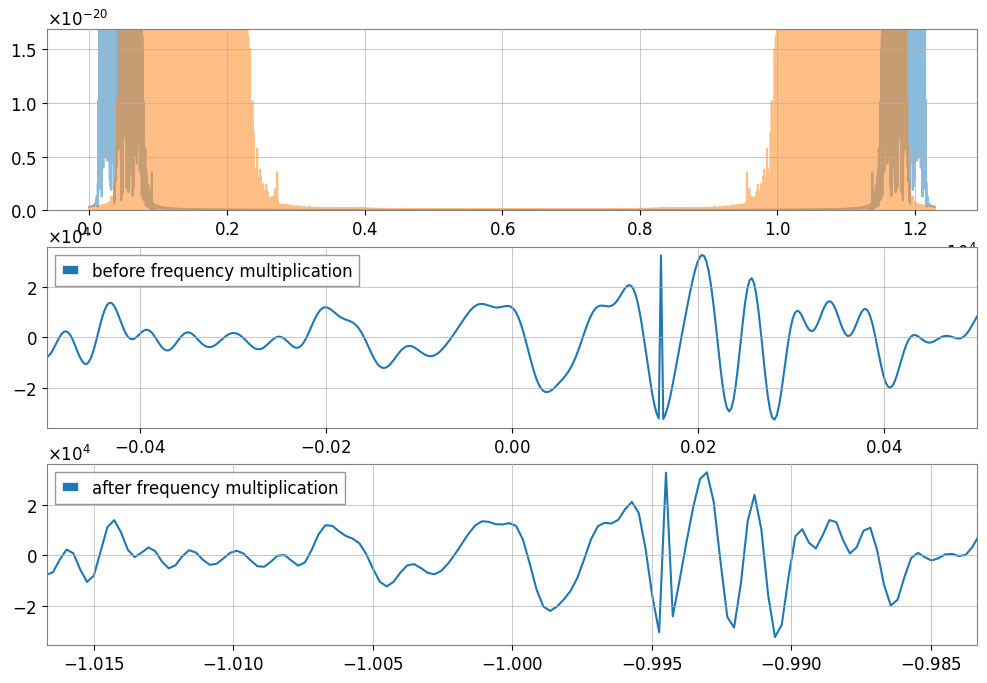

In [117]:
# showing the comparison of old data and data after increasing index
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(np.abs(y_fft_old), alpha=0.5)
plt.plot(np.abs(y_fft_new), alpha=0.5)
ylim = np.percentile(np.abs(y_fft), 95)
plt.ylim(0, ylim)

# showing the frequency before multiplication
plt.subplot(312)
y_old = y_old / np.max(y_old)
plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
plt.xlim(-0.05, 0.05)
plt.legend()

# showing the frequency after multiplication
plt.subplot(313)
y = y / np.max(y)
plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
plt.xlim(-t_clip + t_clip / up_frequency - 0.05 / up_frequency, -t_clip + t_clip / up_frequency + 0.05 / up_frequency)
plt.legend()
print(t_clip / up_frequency)


In [119]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
print("fs = ", fs)
# only record the first third of the data since we only want one sound
write("example.wav", fs, (np.array(y[0:int(num/up_frequency)]) * amplitude).astype(np.int16))
files.download("example.wav")

fs =  4096


<ipython-input-119-abaab4f0758e>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  write("example.wav", fs, (np.array(y[0:int(num/up_frequency)]) * amplitude).astype(np.int16))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>